# [모의 캐글-의료] 흉부 CT 코로나 감염 여부 분류
- 이미지 binary 분류 과제
- 담당: 이녕민M

## Import Libraries

In [ ]:
!apt-get update && apt-get install -y python3-opencv

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [ ]:
!pip install sklearn

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb 10 08:22:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pylab import rcParams
from google.colab import drive
drive.mount('/content/drive/')
from google.colab.patches import cv2_imshow 
import torchvision.transforms.functional as TF
from imgaug import augmentables
import imgaug as ia
import imgaug.augmenters as iaa


Mounted at /content/drive/


## Set Arguments & hyperparameters

In [ ]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [ ]:
os.path.join('/content/drive/MyDrive/이어드림/project2/data')

'/content/drive/MyDrive/이어드림/project2/data'

In [ ]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= '/content/drive/MyDrive/이어드림/project2/data'
NUM_CLS = 2
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 10
INPUT_SHAPE = 128
os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda')

## Dataloader

#### Train & Validation Set loader

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# !unzip -uq '/content/drive/MyDrive/이어드림/project2/test.zip' -d '/content/drive/MyDrive/이어드림/project2'
# !unzip -uq '/content/drive/MyDrive/이어드림/project2/train.zip' -d '/content/drive/MyDrive/이어드림/project2'


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):
        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['COVID']

    

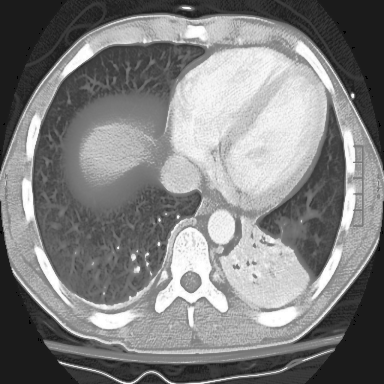

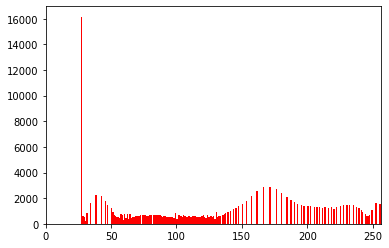

[array([[27, 27, 27, ..., 27, 27, 27],
        [27, 27, 27, ..., 27, 27, 27],
        [27, 27, 27, ..., 27, 27, 27],
        ...,
        [27, 27, 27, ..., 27, 27, 27],
        [27, 27, 27, ..., 27, 27, 27],
        [27, 27, 27, ..., 27, 27, 27]], dtype=uint8)]

In [ ]:


# img_list = []

# def Equalization(data_dir,index):

#     db = pd.read_csv(os.path.join(data_dir, 'train.csv'))
#     data = copy.deepcopy(db.loc[index])
#     cvimg = cv2.imread(os.path.join(data_dir,'train',data['file_name']), 0 )
#     hist,bins = np.histogram(cvimg.flatten(),256,[0,256])    
    
#     cdf = hist.cumsum()
#     cdf_m = np.ma.masked_equal(cdf,0)
#     cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
#     cdf = np.ma.filled(cdf_m,0).astype('uint8')
    
#     cvimg = cdf[cvimg]
    
#     cv2_imshow(cvimg)
#     plt.hist(cvimg.flatten(),256,[0,256], color = 'r')
#     plt.xlim([0,256])
#     plt.show()
#     img_list.append(cvimg)
#     return img_list
# Equalization(DATA_DIR,INPUT_SHAPE)

In [ ]:
####DIR안의 파일명저장#####
traindir = r"/content/drive/MyDrive/이어드림/project2/data/train"
train_files = os.listdir(traindir)
train_ls =[]
test_ls =[]
for i in train_files:
    if os.path.isdir(traindir + r"\\" + i):
        print('ss')
    else :
        if i.count(".") == 1 : 
            V = i.split(".")
            train_ls.append(V[0])
testdir = r"/content/drive/MyDrive/이어드림/project2/data/test"
test_files = os.listdir(testdir)
for i in test_files:
    if os.path.isdir(testdir + r"\\" + i):
        print('ss')
    else :
        if i.count(".") == 1 : 
            V = i.split(".")
            test_ls.append(V[0])

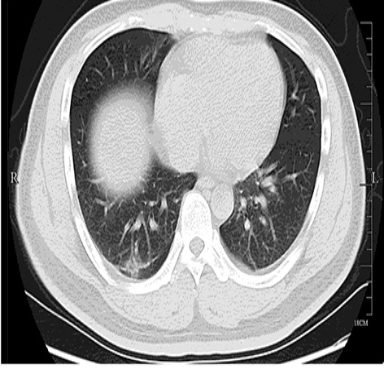

(384, 384)


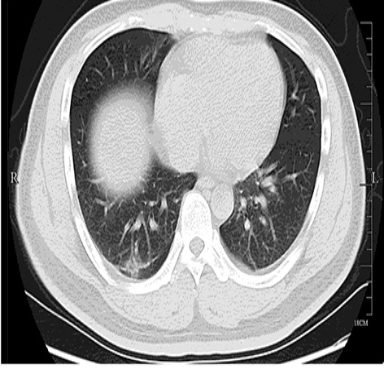

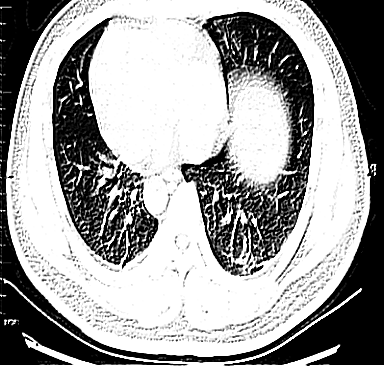

In [ ]:
import imgaug as ia

db = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
data = copy.deepcopy(db.loc[7])
sss =cv2.imread(os.path.join(DATA_DIR,'train',data['file_name']), 0)
cv2_imshow(sss)
print(sss.shape)
augmentation_resize = iaa.Sequential([
                iaa.Resize({"height":384,"width":384},interpolation="cubic")
            ])


image_aug = augmentation_resize(image=sss)
cv2_imshow(image_aug)
# sometimes = lambda aug: iaa.Sometimes(0.5, aug)
augmentation_resize = iaa.Sequential([
                    # iaa.Affine(translate_percent={"x":(-0.5,0.5),"y":(-0.5,0.5)},rotate=(-2,2),scale=(0.5,2)),
                    iaa.Crop(px=(0, 16)),
                    iaa.Multiply((0.8, 1.3)),
                    iaa.LinearContrast((1.5,2.3)),
                    # iaa.GaussianBlur((0.0,3.0)),
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.2),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.95, 1.5)),
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0))])
      
                    
image_augs = augmentation_resize(image=image_aug)
cv2_imshow(image_augs)

                    

In [ ]:
iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    # iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                # iaa.SimplexNoiseAlpha(iaa.OneOf([
                #     iaa.EdgeDetect(alpha=(0.5, 1.0)),
                #     iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                # ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                # iaa.OneOf([
                #     # iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                #     iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                # ]),
                # iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                # # iaa.OneOf([
                #     iaa.Multiply((0.5, 1.5), per_channel=0.5),
                #     iaa.FrequencyNoiseAlpha(
                #         exponent=(-4, 0),
                #         first=iaa.Multiply((0.5, 1.5), per_channel=True),
                #         second=iaa.ContrastNormalization((0.5, 2.0))
                #     )
                # ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                # sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                # sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)
  #             sometimes(iaa.CropAndPad(
        #     percent=(-0.05, 0.1),
        #     pad_mode=ia.ALL,
        #     pad_cval=(0, 255)
        # )),
        # sometimes(iaa.Affine(
        #     scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
        #     translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
        #     rotate=(-45, 45), # rotate by -45 to +45 degrees
        #     shear=(-16, 16), # shear by -16 to +16 degrees
        #     order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
        #     cval=(0, 255), # if mode is constant, use a cval between 0 and 255
        #     mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        # )),
        # # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        


In [ ]:
eq_img_list = []
class Augmentation:
    def __init__(self, data_dir, mode, input_shape):
        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        self.img = None
    
        #이미지크기 저장공간

        self.db = self.data_loader()
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db
    def Equalization(self):
    #    // for cnt in tqdm(range(646)):
        for i in tqdm(range(646)):
            # img = eq_img_list
            db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
            data = copy.deepcopy(db.loc[i])
            cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']))
            cvimg_yuv = cv2.cvtColor(cvimg, cv2.COLOR_BGR2YUV)

            img_clahe = cvimg_yuv.copy()
            clahe = cv2.createCLAHE(clipLimit = 3.0 , tileGridSize=(8,8))
            img_clahe[:,:,0] = clahe.apply(img_clahe[:,:,0])
            img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_YUV2BGR)

                # img_eq = cv2_imshow(img_clahe)
            # cv2.waitKey()
            cv2.destroyAllWindows()
            eq_img_list.append(img_clahe)
            os.makedirs('/content/drive/MyDrive/이어드림/project2/data/aug_img', exist_ok=True)
            cv2.imwrite('/content/drive/MyDrive/이어드림/project2/data/aug_img/{}.png'.format(i), img_clahe)
            self.img = eq_img_list
        return eq_img_list

    def augmentation(self):
        for i in tqdm(range(646)):
            
            db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
            data = copy.deepcopy(db.loc[i])
            sss =cv2.imread(os.path.join(self.data_dir,'train',data['file_name']))
            
            # cv2_imshow(sss)
            augmentation_resize = iaa.Sequential([
                            iaa.Resize({"height":384,"width":384},interpolation="cubic")
                        ])


            image_aug = augmentation_resize(image=sss)
            # cv2_imshow(image_aug)
            # sometimes = lambda aug: iaa.Sometimes(0.5, aug)
            for j in tqdm(range(5)):
                augmentation_resize = iaa.Sequential([
                                    # iaa.Affine(translate_percent={"x":(-0.5,0.5),"y":(-0.5,0.5)},rotate=(-2,2),scale=(0.5,2)),
                                    iaa.Crop(px=(0, 16)),
                                    iaa.Multiply((0.8, 1.3)),
                                    iaa.LinearContrast((1.5,2.3)),
                                    # iaa.GaussianBlur((0.0,3.0)),
                                    iaa.Fliplr(0.5),
                                    iaa.Flipud(0.2),
                                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.95, 1.5)),
                                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0))])
                image_augs = augmentation_resize(image=image_aug)
            # cv2_imshow(image_augs)
                os.makedirs('/content/drive/MyDrive/이어드림/project2/data/augment{}'.format(j), exist_ok=True)
                cv2.imwrite('/content/drive/MyDrive/이어드림/project2/data/augment{}/{}.png'.format(j,i), image_augs)

    def datapreprocess(self):
        aug = [[],[],[],[],[],[]]

        for i in tqdm(range(646)):
            db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
            data = copy.deepcopy(db.loc[i])
            cvimg = cv2.imread(os.path.join(DATA_DIR,'aug_img',data['file_name']))
            aug[5].append(cvimg)
            for j in range(5):
                augimg = cv2.imread(os.path.join(DATA_DIR,'augment{}'.format(j),data['file_name']))
                aug[j].append(augimg)

        
# Equalization(DATA_DIR, )
if __name__ == '__main__':
    temp = Augmentation(DATA_DIR,'train', INPUT_SHAPE) 
    temp.datapreprocess()
    del temp

Loading train dataset..


100%|██████████| 646/646 [00:42<00:00, 15.11it/s]


In [ ]:
aug[5]

IndexError: ignored

In [ ]:
if __name__ == '__main__': 
    temp = Augmentation(DATA_DIR,'train', INPUT_SHAPE)
    print('이미w지를 불러오는 중입니다.')
    temp.data_loader()
    print('*' * 30)
    print('Equalization중 입니다')
    #temp.Equalization()
    print('*' * 30)
    print('Equalization 성공')
    print('Augmentation중 입니다')
    temp.augmentation()

    print('*' * 30)
    del temp
    

file_name    5.png
COVID            1
Name: 5, dtype: object

In [ ]:
DATA_DIR

'/content/drive/MyDrive/이어드림/project2/data'

In [ ]:
db = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
data = copy.deepcopy(db.loc[5])
cvimg = cv2.imread(os.path.join(DATA_DIR,'aug_img',data['file_name']))
equal = []
equal.append(cvimg)
aug = [[],[],[],[],[]]
for i in range(5):
    augimg = cv2.imread(os.path.join(DATA_DIR,'augment{}'.format(i),data['file_name']))
    aug[i].append(augimg)


[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[ 25,  25,  25],
         [ 25,  25,  25],
         [ 25,  25,  25],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 25,  25,  25],
         [ 25,  25,  25],
         [ 25,  25,  25],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 25,  25,  25],
         [ 25,  25,  25],
         [ 25,  25,  25],
         ...,
         [255, 255, 255],
  

## Model

In [ ]:
import torch.nn.functional as F

class custom_CNN(nn.Module):
    def __init__(self, num_classes):
        super(custom_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=25, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=25*29*29, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # (32, 3, 128, 128) -> (32, 8, 62, 62)
        x = self.pool(F.relu(self.conv2(x))) # (32, 8, 62, 62) -> (32, 25, 29, 29)
        
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        output = self.softmax(x)
        
        return output

## Utils
### EarlyStopper

In [ ]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

### Trainer

In [ ]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

### Metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load Dataset & Dataloader

In [ ]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Loading train dataset..
Loading val dataset..
Train set samples: 581 Val set samples: 65


#### Load model and other utils

In [ ]:
# Load Model
model = custom_CNN(NUM_CLS).to(DEVICE)

# # Save Initial Model
# torch.save(model.state_dict(), 'initial.pt')

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn


# Set trainer
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [ ]:
model

custom_CNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 25, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=21025, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

### epoch 단위 학습 진행

In [ ]:
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best.pt')


  0%|          | 0/30 [02:45<?, ?it/s]


KeyboardInterrupt: ignored

## Inference
### 모델 로드

In [ ]:
TRAINED_MODEL_PATH = 'best.pt'

### Load dataset

In [ ]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_name']

In [ ]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


### 추론 진행

In [ ]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

1it [00:00,  2.00it/s]

tensor([[2.4477e-01, 7.5523e-01],
        [9.7876e-01, 2.1241e-02],
        [9.4873e-01, 5.1270e-02],
        [8.8505e-02, 9.1150e-01],
        [9.4120e-01, 5.8802e-02],
        [3.4102e-02, 9.6590e-01],
        [6.6134e-01, 3.3866e-01],
        [1.0559e-01, 8.9441e-01],
        [9.9663e-01, 3.3697e-03],
        [1.4799e-04, 9.9985e-01],
        [7.1211e-01, 2.8789e-01],
        [4.7111e-01, 5.2889e-01],
        [5.0972e-01, 4.9028e-01],
        [9.9901e-01, 9.8963e-04],
        [8.7320e-01, 1.2680e-01],
        [9.2750e-01, 7.2499e-02],
        [2.2544e-01, 7.7456e-01],
        [9.9421e-01, 5.7901e-03],
        [8.1351e-01, 1.8649e-01],
        [9.6152e-01, 3.8485e-02],
        [9.7633e-01, 2.3670e-02],
        [9.5707e-01, 4.2934e-02],
        [8.2227e-01, 1.7773e-01],
        [4.6541e-02, 9.5346e-01],
        [9.9527e-01, 4.7341e-03],
        [9.6138e-01, 3.8620e-02],
        [9.9344e-01, 6.5586e-03],
        [8.4804e-01, 1.5196e-01],
        [3.2955e-02, 9.6704e-01],
        [2.282

2it [00:00,  2.07it/s]

tensor([[5.5841e-01, 4.4159e-01],
        [4.2729e-01, 5.7271e-01],
        [9.7390e-01, 2.6099e-02],
        [4.9798e-01, 5.0202e-01],
        [9.5977e-01, 4.0229e-02],
        [2.7602e-02, 9.7240e-01],
        [5.4470e-01, 4.5530e-01],
        [2.8787e-01, 7.1213e-01],
        [1.7422e-02, 9.8258e-01],
        [3.4740e-01, 6.5260e-01],
        [9.4890e-01, 5.1097e-02],
        [1.5633e-01, 8.4367e-01],
        [3.6200e-01, 6.3800e-01],
        [4.8708e-02, 9.5129e-01],
        [1.7218e-01, 8.2782e-01],
        [9.9974e-01, 2.5714e-04],
        [8.9068e-01, 1.0932e-01],
        [8.0646e-01, 1.9354e-01],
        [2.4595e-01, 7.5405e-01],
        [1.0068e-02, 9.8993e-01],
        [5.9712e-01, 4.0288e-01],
        [7.5618e-01, 2.4382e-01],
        [4.4507e-02, 9.5549e-01],
        [5.7507e-01, 4.2493e-01],
        [2.8404e-01, 7.1596e-01],
        [4.5263e-02, 9.5474e-01],
        [9.9614e-01, 3.8630e-03],
        [2.0267e-01, 7.9733e-01],
        [1.4161e-01, 8.5839e-01],
        [9.803

4it [00:01,  2.65it/s]

tensor([[0.0368, 0.9632],
        [0.0039, 0.9961],
        [0.4126, 0.5874],
        [0.9390, 0.0610],
        [0.0357, 0.9643],
        [0.9280, 0.0720],
        [0.8848, 0.1152],
        [0.9732, 0.0268],
        [0.9975, 0.0025],
        [0.9771, 0.0229],
        [0.0041, 0.9959],
        [0.9988, 0.0012],
        [0.9880, 0.0120],
        [0.8849, 0.1151],
        [0.2213, 0.7787],
        [0.1991, 0.8009],
        [0.0352, 0.9648],
        [0.9180, 0.0820],
        [0.8648, 0.1352],
        [0.2641, 0.7359],
        [0.2458, 0.7542],
        [0.8095, 0.1905],
        [0.4751, 0.5249],
        [0.9404, 0.0596],
        [0.7653, 0.2347],
        [0.4381, 0.5619],
        [0.7915, 0.2085],
        [0.9390, 0.0610],
        [0.8132, 0.1868],
        [0.0134, 0.9866],
        [0.9871, 0.0129],
        [0.5984, 0.4016]])
tensor([[0.4300, 0.5700],
        [0.4291, 0.5709],
        [0.5806, 0.4194],
        [0.3746, 0.6254]])


### 결과 저장

In [ ]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('prediction.csv', index=False)